In [ ]:
#Written by Andrew Hamilton, TLU Physics, Class of 2019
#Part of a research project mentored by Dr. Josh Fuchs during the Summer of 2018

In [2]:
%pylab inline
import csv
from astropy.table import Table
from astropy.io import ascii

Populating the interactive namespace from numpy and matplotlib


# Functions

In [3]:
def survey_data(filename):
    """Survey Data (Cheaty)
    
    Organizes data obtained by manually querying SDSS dr14 or in the format that I used for said manual querying.
    This version makes use of what I consider to be a sneaky little trick to make it applicable to any table that
    consists entirely of floats. 
    
    Args:
        filename (str): Filename of csv file containing data on known LARPs
        
    Returns:
        (Astropy.table): Table of all fo the data from the csv file
    """
    survey_data = csv.reader(open(filename))
    
    survey_rows = []
    
    for line in survey_data:
        survey_rows.append(line)
    
    cheat = []
    for i in range(len(survey_rows[0])):
        cheat.append('float') 
    survey_table = Table(names = (survey_rows[0]), masked = True, dtype = cheat)
    for row in survey_rows[1:]:
        mask_row = []
        for item in row:
            if item == '0':
                mask_row.append(True)
            else:
                mask_row.append(False)
        survey_table.add_row(row, mask = mask_row)
    
    return survey_table

In [4]:
def index_range_finder(color_index, deviations = 1):
    """Color Index Range Finder
    
    Determines the approximate range of a cluster of Color Indices for a LARP
    
    Modelled from a cluster found in the I-Z indices of 8 of the 9 known LARPs
    
    Args:
        color_index (list): contains indices of the known LARPs
        deviations (float?): number of standard deviations from mean to calc range (int or float preferred?)
        
    Returns:
        (float): lower bound of the cluster range
        (float): upper bound of the cluster range
    
    """
    stdev = std(color_index)
    low_bound = mean(color_index)-stdev*deviations
    up_bound = mean(color_index)+stdev*deviations
    
    return low_bound, up_bound

In [5]:
def auto_cluster_finder(data, a, b, threshold = 6):
    """Auto Cluster Finder
    
    Automatically finds potential clusters
    
    Args:
        data (astropy.Table): Astropy data containing however many magnitudes
        a (str): First magnitude, will be subtracted from to get index
        b (str): Second magnitude, will be subtracted from a to get index
        threshold (int): number of stars contained within cluster region for cluster to be considered valid
        
    Returns:
        (list): List containing lbound, ubound, mag_a, mag_b, and if the filter is valid
    """
    
    x = data[a] - data[b]
    c, d = index_range_finder(x)
    count = 0
    for item in x:
        if c <= item and item <= d:
            count += 1 
            
    print(a + '-' + b)
    if count > threshold:
        print('Suitable Filter found!',str(count),'stars in range.')
        print('Lbound:',str(c),', Ubound:',str(d))
        good_filter = True
    else:
        #uncomment the line below if you want it to print for ~every single possible filter~
        #print('Filter unsuitable. Only',str(count),'stars in range.')
        good_filter = False
        
    return [c, d, a, b, good_filter]

In [6]:
def filter_generator(data):
    """Filter Generator
    
    Generates possible filters for LARPs
    
    Args:
        data (astropy.Table): Astropy data
        
    Returns:
        (list): list containing filters using my standard 1-D filter format, includes insufficient ones
    """
    column_names = data.colnames
    
    x = len(column_names)
    indices = []
    for a in range(2,x):
        for b in range(2,x):
            if a < b:
                filt = auto_cluster_finder(data, column_names[a], column_names[b])
                if filt[4]:
                    indices.append(filt)
    return indices

In [7]:
def compare_indices(filt, row):
    """Compare Indices
    
    Determines if an index falls into the filter range
    
    Args:
        filt (list): filter information (in standard 1-D filter format)
        row (astropy.Table): magnitude data on one star
        
    Returns:
        (boolean): Whether or not the star passes all the filter conditions
    """
    a = filt[2]
    b = filt[3]
    x = float(row[a]) - float(row[b])
    
    if filt[0] <= x and filt[1] >= x:
        return True
    else:
        return False

In [14]:
def index_filterator(data):
    """Index Filterator
    
    Stores coordinates of stars that pass filter conditions in table, can be written to file
    
    Args:
        data (astropy.Table): Astropy data
        
    Returns:
        (astropy.Table): Coordinates of LARP candidates
    """
    indices = filter_generator(larp_table)
    names_cheat = larp_table.colnames
       
    possible_larps = Table(names=names_cheat)
    
    for row in data:
        passes_test = []
        for index in indices:
            passes_test.append(compare_indices(index, row))
            
        if False not in passes_test:
            possible_larps.add_row(row)
    
    n_larp_cands = len(possible_larps['ra'])
    
    print('\nThere are',str(n_larp_cands),'potential LARPs in this dataset!')
    
    return possible_larps

In [9]:
def super_tableizer(data):
    """Super Tableizer
    
    Will combine given tables of astro data (as long as the first 2 columns are ra and dec), into one large table
    
    Args:
        Data (list): List containing data tables that you want to combine together
        
    Return:
        (Astropy.Table): Combined Table
    """
    count = 0
    datatable = Table()
    for dataset in data:
        if count == 0:
            for name in dataset.colnames:
                datatable[name] = dataset[name]
        else:
            for name in dataset.colnames[2:]:
                datatable[name] = dataset[name]
        count += 1
                
    return datatable

# Data

In [10]:
known_larps = survey_data('LARP Characteristics-SDSS.csv')
sdss_table = survey_data('Skyserver_SQL6_25_2018 7_25_30 PM.csv')
larps_wise = survey_data('LARP Characteristics-WISE.csv')
wise_table = ascii.read('wise_results.tbl')

In [11]:
larp_data = [known_larps, larps_wise]
larp_table = super_tableizer(larp_data)

In [12]:
survey_data = [sdss_table, wise_table]
survey_table = super_tableizer(survey_data)

In [15]:
prelim_larps = index_filterator(survey_table)

u-g
Filter unsuitable. Only 5 stars in range.
u-r
Filter unsuitable. Only 5 stars in range.
u-i
Suitable Filter found! 7 stars in range.
Lbound: 0.9765358714753771 , Ubound: 3.6101307951912895
u-z
Suitable Filter found! 7 stars in range.
Lbound: 1.4866674706546557 , Ubound: 4.557776973789789
u-W1
Filter unsuitable. Only 5 stars in range.
u-W2
Filter unsuitable. Only 5 stars in range.
u-W3
Filter unsuitable. Only 5 stars in range.
u-W4
Filter unsuitable. Only 6 stars in range.
g-r
Filter unsuitable. Only 5 stars in range.
g-i
Suitable Filter found! 7 stars in range.
Lbound: 0.5918975161702303 , Ubound: 2.379213594940882
g-z
Suitable Filter found! 8 stars in range.
Lbound: 1.1078569863241488 , Ubound: 3.321031902564741
g-W1
Filter unsuitable. Only 4 stars in range.
g-W2
Filter unsuitable. Only 5 stars in range.
g-W3
Filter unsuitable. Only 6 stars in range.
g-W4
Filter unsuitable. Only 5 stars in range.
r-i
Filter unsuitable. Only 6 stars in range.
r-z
Suitable Filter found! 7 stars in r

Text(0,0.5,'G-I')

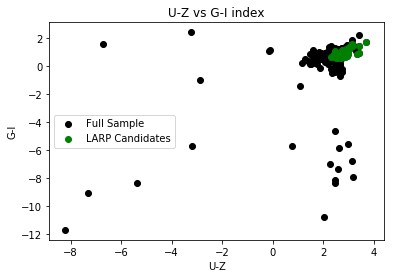

In [25]:
scatter(sdss_table['u']-sdss_table['z'],sdss_table['g']-sdss_table['i'], color = 'k', label = 'Full Sample')
scatter(prelim_larps['u']-prelim_larps['z'], prelim_larps['g']-prelim_larps['i'], color = 'g', label = 'LARP Candidates')
legend()

title('U-Z vs G-I index')
xlabel('U-Z')
ylabel('G-I')